<font size="5.5"><u><i>Process Phenomenological Waveforms</i></u></font>

<font size="4">Application of injections, data conditioning, and generation of strain samples dataset containing noise + GW.</font>
</br>
<font size="4">Author: Manuel David Morales</font>

## 1. Library imports

In [1]:
# Data analysis
import numpy as np 
import pandas as pd
import math

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# Files/folders management
import os, glob, sys, re

# To read csv files
import csv

# Scientific computing
from scipy import signal

# Garbage collector
import gc

# Object serialization
import pickle

# Show time execution
import time as tm

# Toolbox functions
from Toolbox import PSD, SNR, SNR_PyCBC, whitening_PyCBC, filt_bandpass_PyCBC, WaveletTF_transform

/home/manuel/.programs/anaconda3/lib/python3.9/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


### 1.1 Function to compute execution time

In [2]:
def execution_time(ini_time, end_time, exe_time_t):
    
    exe_time = end_time - ini_time
    exe_time_tot = exe_time_t + exe_time
    
    print("")
    print("===========================================================================")
    print(f"Execution time current cell (seconds): {exe_time}")
    print(f"Total execution time (seconds): {exe_time_tot}")

    return exe_time_tot

In [3]:
exe_time_t = 0.0

## 2. Make Injections

### 2.1. Input parameters

In [4]:
ini_time = tm.time()

# Interferometer for noise data
# ------------------------------------------------------------
detector = "H1"   # Options: "L1", "H1", "V1"
# ------------------------------------------------------------

# Class of waveforms to be injected
# ------------------------------------------------------------
waveform_class = "1"   # Options: "1", "2", "3"
# ------------------------------------------------------------

# Seed for the random selection of waveforms to be injected
# ----------------------------------------------------------------
rdm_seed = 23     #  Options: 23 for noise gps_start 1256783872
                  #           42 for noise gps_start 1257050112
# ----------------------------------------------------------------

# Time between injections (in seconds)
# ------------------------------------------------------------
dt_inj = 8   # Options: 8, 12, 16, 32, 64
# ------------------------------------------------------------

# Jitter_lim: This value defines a fluctuation range, in which each
# injection will be located on a random sample in the interval
# [inj_time - jitter_lim, inj_time + jitter_lim] (in seconds)
# ------------------------------------------------------------
jitter_lim = 0.01   # Options: 0.3, 0.1, 0.0, 1.2, etc.
# ------------------------------------------------------------

# Time segment for SNR calculation around injection (in seconds)
# ----------------------------------------------------------------
t_segment = 4   #  [ t_inj-t_segment/2 , t_inj+t_segment/2 ] 
# ----------------------------------------------------------------

# ------> Input parameters for brief exploration and debugging

# Work on a reduced noise segment?
# ----------------------------------------------------------------
reduce_segment = 0   #  1: yes | 0: no
# ----------------------------------------------------------------

# Length of the reduced noise segment (in seconds)
# ----------------------------------------------------------------
reduced_time_n = 160.0                     
# ----------------------------------------------------------------

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)


Execution time current cell (seconds): 0.0006825923919677734
Total execution time (seconds): 0.0006825923919677734


### 2.2. Read files

#### 2.2.1 Noise data

In [5]:
ini_time = tm.time()

# ------> Specify folder locations

rawdata_dir = '/home/manuel/Research Projects/GW Data analysis/GitHub/datagen-sngw-phen/Codes/'

# ------> Initialize lists

time_noise = []
strain_noise = []
F_noi = []

# ------> Scan noise files

os.chdir(rawdata_dir)

for file in glob.glob("strain_noise_" + detector + "*"):
    F_noi.append(file)

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)


Execution time current cell (seconds): 0.001895904541015625
Total execution time (seconds): 0.0025784969329833984


In [6]:
ini_time = tm.time()

# ------> Load noise data 

result = re.search( detector + "_", F_noi[0])
ind_ini_n = result.span()[1]
result = re.search( ".txt", F_noi[0])
ind_end_n = result.span()[0]

print("Available noise segments (in GPS start time)")
for j in range(len(F_noi)):
    print("GPS =", F_noi[j][ind_ini_n:ind_end_n], "  |  Input option :", j)
print("")

nfile_i = input("======> Enter your option:")
nfile_i = int(nfile_i)
print("")

print("***** READING FILE", F_noi[nfile_i], " *****")

with open(F_noi[nfile_i]) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Data columns: {", ".join(row)}')
            line_count += 1
        else:
            time_noise.append(row[0])
            strain_noise.append(row[1])
            #print(f'\t{row[0]} works in the {row[1]}.')
            line_count += 1
    print(f'Processed {line_count} lines')

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)

Available noise segments (in GPS start time)
GPS = 1256783872   |  Input option : 0



======> Enter your option: 0



***** READING FILE strain_noise_H1_1256783872.txt  *****
Data columns: time, strain
Processed 16777217 lines

Execution time current cell (seconds): 21.968888759613037
Total execution time (seconds): 21.97146725654602


In [7]:
ini_time = tm.time()

# ------> Convert lists to numpy arrays, clear memory from lists

time_n = np.array(time_noise, dtype='float64')
del(time_noise)
gc.collect()

strain_n = np.array(strain_noise, dtype='float64')
del(strain_noise)
gc.collect()

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)


Execution time current cell (seconds): 9.383814811706543
Total execution time (seconds): 31.355282068252563


### 2.3. Injections preparation

In [8]:
# Compute sampling time

ts = time_n[1] - time_n[0]

# -------> JUST FOR DEBUGGING THE IMPLEMENTATION
#          Select a portion of the noise strain data

if reduce_segment:
    
    reduced_length = int(reduced_time_n/ts)     # Reduced noise arrays' length (in sample units)
    
    time_n = np.delete(time_n,np.arange(reduced_length, len(time_n), 1, dtype=int))
    strain_n = np.delete(strain_n,np.arange(reduced_length, len(strain_n), 1, dtype=int))
    
    #print("time_n vector:", time_n)
    print("**** length of time_n (in seconds):", len(time_n)*ts)
    print("**** length of time_n (in sample units):", len(time_n))
    print("**** length of strain_n (in sample units):", len(strain_n))

In [9]:
# ------> Backup original strain arrays
strain_n_new = np.copy(strain_n) # ---> Deep copy in numpy, to unbind arrays

# ------> Print useful input information

# Sampling frequency
fs =1/ts
print("Sampling frequency (in Hz): ", fs)

# Index of the strain noise sample (point) in which the first injection will be performed
N_lapse = int(dt_inj/(1./fs))
print("First noise sample to be injected with a waveform (without jitter): ", N_lapse)
print("Its correspondent strain value:", strain_n_new[N_lapse])

# Number of injections to be performed in the strain data
N_inj = int(len(strain_n_new) / N_lapse) - 1 
# Remark: -1 value in N_inj is just to avoid incomplete injection at the right edge.  
print("Number of injections to be performed: ", N_inj)

Sampling frequency (in Hz):  4096.0
First noise sample to be injected with a waveform (without jitter):  32768
Its correspondent strain value: 7.136150961698782e-20
Number of injections to be performed:  511


#### 2.3.1 Read waveform data

In [10]:
ini_time = tm.time()

# ------> Load waveforms dictionaries

# Waveforms strain
with open('../Waveforms_mod/Phen/waveforms.pkl', 'rb') as fp:
    waveforms = pickle.load(fp)
    print('waveforms dictionary loaded successfully')

# Waveforms log data
with open('../Waveforms_mod/Phen/waveforms_log.pkl', 'rb') as fp:
    waveforms_log = pickle.load(fp)
    print('waveforms_log dictionary loaded successfully')
    
# Remark: How to access waveforms and log data
# waveforms["class c"][n]  ---> to extract n-th waveform of class c
# waveforms_log["class c"][n]  ---> to extract log data of n-th waveform of class c

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)

waveforms dictionary loaded successfully
waveforms_log dictionary loaded successfully

Execution time current cell (seconds): 0.039910316467285156
Total execution time (seconds): 31.39519238471985


In [11]:
# Checks
print(len(waveforms["class 1"]))
print(len(waveforms["class 2"]))
print(len(waveforms["class 3"]))

200
200
200


In [12]:
ini_time = tm.time()

# ------> Select random waveforms for injections

# Predictable random numbers
np.random.seed(rdm_seed)

# Select N_inj random injections for the chosen class
inj_ind = np.random.choice(len(waveforms["class " + waveform_class]), N_inj)

# Print indexes of selected waveform for injection
print("Choosen waveforms: ", inj_ind)

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)

Choosen waveforms:  [ 83  40 182  31  91  39  90 153 179   6 123 173  12  49 194 197 192  12
  21  48  41  79  90 190  57 147 161 187  39 143  36  65 129 116 171  15
 103 186 118  25 194 125  35  56  13  60  22 166  31  94   0 149   6  32
  98  32 142  31  78  80  70  66 183  27  62  43  71 170  21   6  68 150
  43 136 190 160  60 100  11   1  41  26  37 169  56  39 160 181  35  23
 106  29  42 166   4  93  32  50  85  27 161 104  91 162   0 139  62 118
 182 113  41 198 133   7   4 144 102   9  56  48 111 171  62 198  31 130
   0  15  32 176  15  61 130  34  22 170  66 104  89 129  78  53  80 191
  84  87  70 130 187 173  23  23  88  85 159 188 106   3  49  62 126   9
 149  65  81 102  11  68  80 157  99  99 138 199  20 120  33  17   6 121
 164 138  49  35 153 114 170  30 180 128   9 102 169 157 152 109   4 130
 113   1 169  99 116  54 146  98 184   3  35 149  76 116  57  86  81 128
 100 120 196 149 180  93  21  96  60  67  99  60 124 137 141 163   6 190
  71  41  47  41 126 120  52 10

### 2.4. Injections application

In [13]:
ini_time = tm.time()

doplots_snr = 0 # Do plots in SNR calculation (checks)

# ------> Create array to locate injections by indexes

locate_inj = np.arange(1,N_inj+1)
locate_inj = N_lapse*locate_inj
#print(locate_inj[-1] + N_lapse)
#print(len(strain_n_new))

# ------> Define length of local noise segment for SNR calculation

epsilon = int(int(t_segment/ts)*0.5)
#print("Epsilon = ", epsilon)

# ------> Initialize list for log file

log_data = []

# ------> Make injections

# FIRST LOOP, j index: injection count variable
# -----------------------------------------------

for j in range(N_inj): # Apply N_inj injections
#for j in range(10): # Apply only a few injections
        
    print("Injection No.", j)
    print("----------------------")
    
    # ------> Load random waveform indexed by inj_ind array
    
    strain_wf = np.transpose(waveforms["class " + waveform_class][inj_ind[j]])[1]
    
    # ------> Load waveform log data
    
    slope = waveforms_log["class " + waveform_class][inj_ind[j]][0]
    f0 = waveforms_log["class " + waveform_class][inj_ind[j]][1]
    f1 = waveforms_log["class " + waveform_class][inj_ind[j]][2]
    wf_duration = waveforms_log["class " + waveform_class][inj_ind[j]][3]
    
    slope = float(slope)
    f0 = float(f0); f1 = float(f1)
    wf_duration = float(wf_duration)
    
    # ------> Injection location without jitter
    
    ind_noise = locate_inj[j] # Locate first point of the injection
    # print("Injection first point in the strain noise data (without jitter):", ind_noise)
    
    time_inj = (1./fs)*ind_noise
    print("Time injection, without jitter (in seconds):", time_inj)
    
    # ------> Jitter variable procedure
    
    # Define the jitter range in terms of sample units
    njitter_range_min = ind_noise + int(-jitter_lim/(1./fs))
    njitter_range_max = ind_noise + int(jitter_lim/(1./fs))
    njitter_range = np.arange(njitter_range_min, njitter_range_max + 1, 1, dtype=int)

    # Compute actual location of the injection in sample units
    njitter = np.random.choice(njitter_range, 1)[0]
    
    # Some checks
    #print("Jitter variable range (in sample units):", njitter_range)
    #print("Modified injection location (in sample units):", njitter)
    current_jitter = (njitter-ind_noise)*(1/fs)
    print("Current jitter (in seconds):", current_jitter)
    
    time_inj_jit = njitter*(1/fs)
    print("Time injection, with jitter (in seconds):", time_inj_jit)

    # ------> Update index injection locations
    
    locate_inj[j] = njitter 
    
    
    # SECOND LOOP, k index: Waveform's sample count variable
    # --------------------------------------------------------
    
    for k in range(len(strain_wf)): # Injection along waveform's ALL points
    #for k in range(3): # Injection along waveform's first three points
    #for k in reversed(range(len(strain_wf)-3,len(strain_wf),1)): # Injection along waveform's last three points
        
        #print("")
        #print("+++++ Point", k, " of the waveform")
        
        strain_waveform = strain_wf[k] 
        #print("------> strain waveform", strain_waveform)
        
        strain_noise = strain_n_new[locate_inj[j]+k]
        #print("------> strain BEFORE injection", strain_noise)
    
        # PERFORM THE INJECTION (k point in the waveform, locate_inj[j] + k point in the noise)
        strain_with_inj = strain_noise + strain_waveform
        strain_n_new[locate_inj[j]+k] = strain_with_inj
    
        #print("------> strain AFTER injection", strain_n_new[ind_noise+k])
        #print("------> strain AFTER injection in copy", strain_n[ind_noise+k])
    
    print("")
    #print("+++++ SNR calculation +++++")
    
    # ------> Define time segment for SNR calculation around the injection
    
    Llim_local_noise = ind_noise - epsilon
    Rlim_local_noise = ind_noise + len(strain_wf) + epsilon
    
    #print("Left limit local noise = ", Llim_local_noise)
    #print("Right limit local noise = ", Rlim_local_noise)
    
    #print("Strain noise length (in sample units):", len(strain_n_new))
    
    # Define strain noise segment
    strain_segment = strain_n_new[Llim_local_noise:Rlim_local_noise+1]
    
    #print("Strain noise segment length (in sample units):", len(strain_segment))
    
    # ------> Compute PSD
    
    # Size of Welch's segments
    nperseg = int(4*fs)
    
    # Double-sided power spectral density of raw strain data
    fpsd, psd = PSD(strain_segment,fs,nperseg,2)
    
    # Sort arrays, increasing frequencies
    ind = np.argsort(fpsd)
    fpsd = np.sort(fpsd)
    psd = psd[ind]
    
    # ------> Compute SNR values (with ScyPy)
    
    #SNR_value = SNR(strain_wf,time_wf,fpsd,psd,doplots_snr)
 
    #print("Injection SNR value (SciPy): ", SNR_value)
    
    # ------> Compute SNR values (with PyCBC)
    
    SNR_value = SNR_PyCBC(strain_wf, strain_segment, fs, doplots_snr)
    
    if np.isnan(SNR_value):
            
        print("!!!!!!!!!!!!!!!!! STOPPING INJECTION PROCEDURE, SNR VALUE IS \"NAN\" !!!!!!!!!!!!!!!!! ")
        break
    
    # ------> Print relevant log information
    
    print("G-mode slope =", slope)
    #print("G-mode start frequency , f0 = ", f0)
    #print("G-mode end frequency , f1 = ", f1)
    print("Waveform duration =", wf_duration)
    print("Injection SNR value (PyCBC): ", SNR_value)
        
    # ------> Save information in log_data list
    # Injection time, jitter, SNR value, waveform duration
    log_data.append([time_inj_jit, current_jitter, SNR_value, slope, f0, f1, wf_duration])
    
    print("****************************************************************")
    print("")        
    
end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)

Injection No. 0
----------------------
Time injection, without jitter (in seconds): 8.0
Current jitter (in seconds): 0.003173828125
Time injection, with jitter (in seconds): 8.003173828125

G-mode slope = 2469.0
Waveform duration = 0.45654296875
Injection SNR value (PyCBC):  25.63629794126693
****************************************************************

Injection No. 1
----------------------
Time injection, without jitter (in seconds): 16.0
Current jitter (in seconds): 0.000244140625
Time injection, with jitter (in seconds): 16.000244140625

G-mode slope = 1945.0
Waveform duration = 0.3359375
Injection SNR value (PyCBC):  26.783485315441325
****************************************************************

Injection No. 2
----------------------
Time injection, without jitter (in seconds): 24.0
Current jitter (in seconds): 0.00390625
Time injection, with jitter (in seconds): 24.00390625

G-mode slope = 1956.0
Waveform duration = 0.364013671875
Injection SNR value (PyCBC):  25.3387603

In [14]:
ini_time = tm.time()

# ------> Rename arrays to pass them to next section

t = time_n               # Time
s_raw =  strain_n_new    # Raw strain data

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)


Execution time current cell (seconds): 0.00028133392333984375
Total execution time (seconds): 64.86139726638794


## 3. Pre-process Data

### 3.1. Input parameters

In [15]:
ini_time = tm.time()

# Filter's frequency band
# ------------------------------------------------------------
set_band = np.array([100,1800])  # frequency band (in Hz)
# ------------------------------------------------------------

# Remark, about the frequency band:
# This choice is important, in order to capture the HFF, which cover a wide
# region in the frequency domain. It is important to guide our choise in
# the original TF plots for the waveforms before injected to noise.

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)


Execution time current cell (seconds): 6.413459777832031e-05
Total execution time (seconds): 64.86146140098572


### 3.1. Pre-processing preparation

In [16]:
ini_time = tm.time()

# ------> Count samples in the data segment

Nsamples = len(t)
print("Num of samples in raw strain segment: ", Nsamples)

# ------> Check

if Nsamples % 2 == 1:
    raise ValueError('Nsamples is odd')

# ------> Compute sampling freq and time

fs = 1 / (t[1]-t[0])  # Sampling frequency
ts = 1 / fs           # sampling time

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)

Num of samples in raw strain segment:  16777216

Execution time current cell (seconds): 0.0031652450561523438
Total execution time (seconds): 64.86462664604187


### 3.2. Whitening application

In [17]:
ini_time = tm.time()

# ------> Whitening input parameters

doplots_white = 0     # Do plots for check

seg = 4.0 #0.5              # Welch's segments size (in seconds)
nperseg = int(seg*fs)       # Welch's segments size (in sample units)
nfft = Nsamples             # FFT size (in sample units)

# Only for PyCBC implementation

cut = 10.0 # This is the cut's length (in seconds) to remove edge artifacts
           # in whitened strain data: (cut/2) at left edge, (cut/2) at right edge
    
end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)


Execution time current cell (seconds): 0.000522613525390625
Total execution time (seconds): 64.86514925956726


In [18]:
ini_time = tm.time()

# ------> Apply whitening to raw strain data

s_white_t, psd_raw, fpsd_raw, psd_white, fpsd_white = whitening_PyCBC(s_raw, seg, cut, ts, doplots_white)

t_white = s_white_t.sample_times

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)


Execution time current cell (seconds): 64.69230389595032
Total execution time (seconds): 129.55745315551758


In [19]:
ini_time = tm.time()

# ------> Convert PyCBC elements to numpy arrays

t_white = np.array(t_white, dtype='float64')
s_white_t = np.array(s_white_t, dtype='float64')
psd_white = np.array(psd_white, dtype='float64')
fpsd_white = np.array(fpsd_white, dtype='float64')

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)


Execution time current cell (seconds): 0.13173460960388184
Total execution time (seconds): 129.68918776512146


### 3.3. Band-pass filtering application

In [20]:
ini_time = tm.time()

# ------> Input parameters

doplots_bp = 0              # Do plots for check
n_order = 8                 # Filter's order
band = set_band

seg = 4.0 #0.5              # Welch's segments size (in seconds)
nperseg = int(seg*fs)       # Welch's segments size (in sample units)

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)


Execution time current cell (seconds): 0.0002760887145996094
Total execution time (seconds): 129.68946385383606


In [21]:
ini_time = tm.time()

# ------> Apply band-pass filtering to whitened strain data

s_filt_t, psd_filt, fpsd_filt = filt_bandpass_PyCBC(s_white_t, n_order, band, ts, seg, doplots_bp)

t_filt = s_filt_t.sample_times

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)


Execution time current cell (seconds): 41.04287528991699
Total execution time (seconds): 170.73233914375305


In [22]:
ini_time = tm.time()

# ------> Convert PyCBC elements to numpy arrays

t_filt = np.array(t_filt, dtype='float64')
s_filt_t = np.array(s_filt_t, dtype='float64')
psd_filt = np.array(psd_filt, dtype='float64')
fpsd_filt = np.array(fpsd_filt, dtype='float64')

# ------> Displace time of filtered strain data

t_filt = t_filt + t_white[0]

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)


Execution time current cell (seconds): 0.1431884765625
Total execution time (seconds): 170.87552762031555


### 3.4. Sanity checks

#### 3.4.1. Spectrogram: White+Filt

In [23]:
# ------> Check: Plot spectrogram

# Remark: This visual check is useful for a noise segment with a few injections

doplot_spectrogram = 0

wnd="hamming" # Window for spectrograms

if doplot_spectrogram:
    
    freq, time, Sxx = signal.spectrogram(s_filt_t, fs, window=wnd, nperseg=1024)
    #time, freq, WL = WaveletTF_transform(s_filt_t, fs, 1, 2000, 5, 7, 0)
    
    plt.figure(1,figsize=(6.5,5))
    plt.pcolormesh(time+t_filt[0], freq, Sxx, shading='gouraud')
    plt.ylabel('Frequency [Hz]', fontsize=14)
    plt.xlabel('Time [sec]', fontsize=14)
    plt.show()
    plt.figure(2).clear()
    gc.collect(1)

#### 3.4.2. Strain data: Raw, White, Whit+Filt

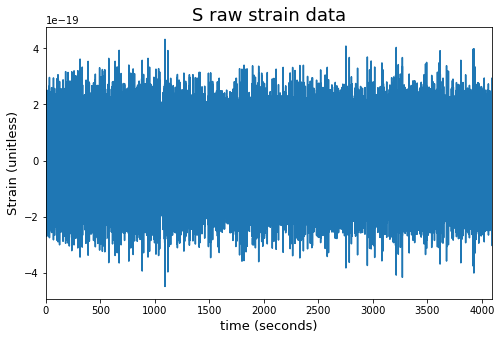

<Figure size 432x288 with 0 Axes>

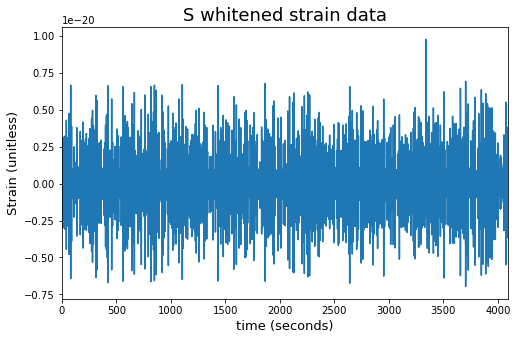

<Figure size 432x288 with 0 Axes>

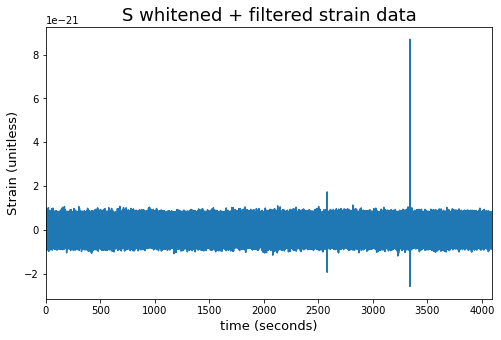

<Figure size 432x288 with 0 Axes>

In [24]:
doplot_strains = 1

# ------> Check: Plot raw/whitened/filtered strain data

if doplot_strains:
    
        
    t_min = np.min(t); t_max = np.max(t)
    
    plt.figure(1, figsize=(8,5))
    plt.plot(t, s_raw)
    plt.title("S raw strain data", fontsize=18)
    plt.ylabel("Strain (unitless)", fontsize=13)
    plt.xlabel("time (seconds)", fontsize=13)
    plt.xlim(left=t_min, right=t_max)
    plt.show()
    plt.figure(1).clear()
    gc.collect()

    plt.figure(2, figsize=(8,5))
    plt.plot(t_white, s_white_t)
    plt.title("S whitened strain data", fontsize=18)
    plt.ylabel("Strain (unitless)", fontsize=13)
    plt.xlabel("time (seconds)", fontsize=13)
    plt.xlim(left=t_min, right=t_max)
    plt.show()
    plt.figure(2).clear()
    gc.collect()

    plt.figure(3, figsize=(8,5))
    plt.plot(t_filt, s_filt_t)
    plt.title("S whitened + filtered strain data", fontsize=18)
    plt.ylabel("Strain (unitless)", fontsize=13)
    plt.xlabel("time (seconds)", fontsize=13)
    plt.xlim(left=t_min, right=t_max)
    plt.show()
    plt.figure(3).clear()
    gc.collect()

#### 3.4.3 Amplited Spectral Density (ASD)

In [25]:
# ------> Compute ASD quantities

# Raw strain data ASD
# ---------------------

asd_raw = np.sqrt(psd_raw)

# Whitened strain data ASD
# --------------------------

asd_white = np.sqrt(psd_white)

# Filtered strain data ASD
# --------------------------

asd_filt = np.sqrt(psd_filt)

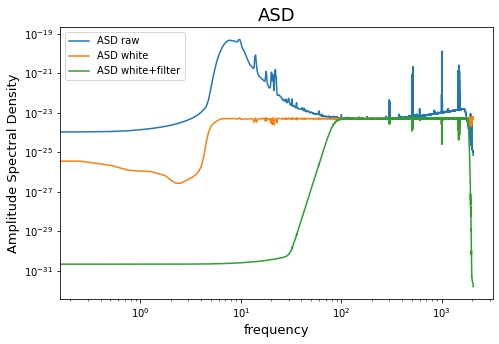

14097

<Figure size 432x288 with 0 Axes>

In [26]:
# Plot ADS for raw/whitened/filtered strain data

#mpl.rcParams['agg.path.chunksize'] = 10000

plt.figure(figsize=(7.75,5))
plt.plot(fpsd_raw, asd_raw, label='ASD raw')
plt.plot(fpsd_white, asd_white, label='ASD white')
plt.plot(fpsd_filt, asd_filt, label='ASD white+filter')
#plt.xlim(left=9)
plt.xscale('log')
plt.yscale('log')
plt.title("ASD", fontsize=18)
plt.ylabel("Amplitude Spectral Density", fontsize=13)
plt.xlabel("frequency", fontsize=13)
plt.legend()
plt.show()
plt.figure().clear()
gc.collect()

In [27]:
ini_time = tm.time()

# ------> Rename arrays to pass them to next section

t = t_filt      # Time
s = s_filt_t    # Pre-processed strain data

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)


Execution time current cell (seconds): 6.29425048828125e-05
Total execution time (seconds): 170.87559056282043


## 4. Build Strain Data

### 4.1. Input parameters

In [28]:
ini_time = tm.time()

# ------> Input parameters for window samples generation

# Scalar parameter in window time for samples (in seconds)
# ------------------------------------------------------------
alpha = 0.02001    # alpha must be greater than 2*jitter_lim
# ------------------------------------------------------------

# Range for SNR values
# --------------------------------------------------------------------
SNR_max = 50.0    # Options: 100 (high SNRs), 50 (low SNRs)
SNR_min = 12.0    # Options: 0 (high SNRs); 12 (low SNRs)
# --------------------------------------------------------------------

# Plot windows samples (time & TF domain)
# ------------------------------------------------------------
set_doplots = 0    #  1: yes | 0: no
# ------------------------------------------------------------

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)


Execution time current cell (seconds): 0.0004208087921142578
Total execution time (seconds): 170.87601137161255


In [29]:
# ------> Check

if alpha <= 2*jitter_lim:
    print("")
    print("******** Error: alpha must be greater than 2*jitter_lim ********")
    print("")
    
    raise SystemExit("Code stopped here!")
    
else:
    pass

# Remark: The condition alpha > 2*jitter_lim ensures that
#         the whole injected waveform will be in the window sample.

### 4.2. Window samples preparation

In [30]:
ini_time = tm.time()

# ------> Compute maximum waveform duration (in seconds)

# Remark: For this calculation, we consider all waveforms saved on Waveforms folder

waveforms_dir = "/home/manuel/Research Projects/GW Data analysis/GitHub/datagen-sngw-phen/Waveforms_mod/Phen/"

# Load waveforms log data dictionary
with open(waveforms_dir + "waveforms_log.pkl", 'rb') as fp:
    waveforms_log = pickle.load(fp)
    
# Extract duration of all waveforms

wf_duration_all = []

label = ["class 1", "class 2", "class 3"]

for class_wf in label:
    for i in range(len(waveforms_log[class_wf])):
        wf_duration_i = waveforms_log[class_wf][i][3]
        wf_duration_all.append(float(wf_duration_i))

# Compute maximum duration
        
wf_max = max(wf_duration_all)

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)


Execution time current cell (seconds): 0.0035216808319091797
Total execution time (seconds): 170.87953305244446


In [31]:
ini_time = tm.time()

# ------> Define a UNIQUE time window duration (in seconds)

Twin = wf_max + alpha

Twin_rounded = math.ceil(Twin * 1e5) / 1e5

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)


Execution time current cell (seconds): 0.0003142356872558594
Total execution time (seconds): 170.8798472881317


In [32]:
# ------> Print waveforms information

print("Maximum waveform duration (in seconds)")
print("wf_max = ", wf_max)
print("")
print("Alpha scalar parameter (in seconds)")
print("alpha = ", alpha)
print("")
print("Duration of window strain samples (in seconds)")
print("Twin = wf_max + alpha = ", Twin)
print("Twin rounded = ", Twin_rounded)

# Use Twin_rounded hereinafter

Twin = Twin_rounded

Maximum waveform duration (in seconds)
wf_max =  0.94970703125

Alpha scalar parameter (in seconds)
alpha =  0.02001

Duration of window strain samples (in seconds)
Twin = wf_max + alpha =  0.96971703125
Twin rounded =  0.96972


In [33]:
ini_time = tm.time()

# ------> Recover information from log_data file

inj_time = []
jitt = []
SNR_waveform = []
gmode_slope = []
f0 = []
f1 = []
duration_wf = []


for i in range(len(log_data)):
    inj_time.append(log_data[i][0])
    jitt.append(log_data[i][1])
    SNR_waveform.append(log_data[i][2])
    gmode_slope.append(log_data[i][3])
    f0.append(log_data[i][4])
    f1.append(log_data[i][5])
    duration_wf.append(log_data[i][6])

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)


Execution time current cell (seconds): 0.0013265609741210938
Total execution time (seconds): 170.88117384910583


In [34]:
ini_time = tm.time()

# ------> Convert lists to numpy arrays, clear memory from lists

t_inj = np.array(inj_time, dtype='float64')
del(inj_time)
gc.collect()

jitter = np.array(jitt, dtype='float64')
del(jitt)
gc.collect()

wf_SNR = np.array(SNR_waveform, dtype='float64')
del(SNR_waveform)
gc.collect()

Slope = np.array(gmode_slope, dtype='float64')
del(gmode_slope)
gc.collect()

f_ini = np.array(f0, dtype='float64')
del(f0)
gc.collect()

f_end = np.array(f1, dtype='float64')
del(f1)
gc.collect()

wf_duration = np.array(duration_wf, dtype='float64')
del(duration_wf)
gc.collect()

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)


Execution time current cell (seconds): 0.4592626094818115
Total execution time (seconds): 171.34043645858765


In [35]:
ini_time = tm.time()

# ------> Initialize array for initial times of each sample window

Twin_ini = np.zeros(len(t_inj))

# ------> Populate above array with time values

for i in range(len(t_inj)): # Select all windows
#for i in range(10): # Select only a few windows
    
    # Remark: The following expression ensures beforehand that each window sample
    #         is such that its injection, without jitter variation, is centered.
    
    Twin_ini[i] =  t_inj[i] + 0.5 * ( wf_duration[i] - Twin ) - jitter[i]
    #print(Twin_ini[i])

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)


Execution time current cell (seconds): 0.0004799365997314453
Total execution time (seconds): 171.34091639518738


In [36]:
ini_time = tm.time()

# ------> Check if window samples at the edges are in the segment

# RIGHT edge of data segment
for i in range(len(Twin_ini)):
    
    if Twin_ini[0] < t[0]:
        print("****** WARNING: Sample at LEFT edge is outside the data segment, it will be removed")
        Twin_ini = np.delete(Twin_ini,0)
        # We also remove the injection
        t_inj = np.delete(t_inj,0)
    else:
        print("End LEFT segment check")
        break

# RIGHT edge of data segment
for i in range(len(Twin_ini)):
    
    #if Twin_ini[-i-1] + Twin > t[-i-1]: # SE CORRIGIO ESTO!!!!
    if Twin_ini[-1] + Twin > t[-1]: 
        print("****** WARNING: Sample at RIGHT edge is outside the data segment, it will be removed")
        #Twin_ini = np.delete(Twin_ini,-i-1) # SE CORRIGIO ESTO!!!!
        Twin_ini = np.delete(Twin_ini,-1)
        # We also remove the injection
        t_inj = np.delete(t_inj,-i-1)
    else:
        print("End RIGHT segment check")
        break

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)

End LEFT segment check
End RIGHT segment check

Execution time current cell (seconds): 0.002260923385620117
Total execution time (seconds): 171.343177318573


In [37]:
ini_time = tm.time()

# ------> Convert Twin_ini values (in seconds) to locating indexes

ts = t[1]-t[0]

locate_win = np.zeros(len(Twin_ini))

for i in range(len(Twin_ini)):    
    locate_win[i] = int(Twin_ini[i]/ts) - int(t[0]/ts)

locate_win = locate_win.astype(int)

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)


Execution time current cell (seconds): 0.0013535022735595703
Total execution time (seconds): 171.34453082084656


In [38]:
# ------> Checks: Twin_ini vs. t_inj

print("Length of vector for time injections: ", len(t_inj))
print("Length of vector for windows's initial time: ", len(Twin_ini))
#print("Length of locate_win vector : ", len(locate_win))
print("Length of window samples (in seconds) : ", Twin)

for i in range(len(Twin_ini)):
    if t_inj[i] <= Twin_ini[i]:
        print("")
        print("****** WARNING: At sample", i, "Injection's start is outside the window (LEFT)")
        print("Window's initial time (seconds) =", Twin_ini[i])
        print("Injection initial time (seconds) =", t_inj[i])
        print("----------------------------------------------")
        print("")
    elif t_inj[i]+wf_duration[i] >= Twin_ini[i]+Twin:
        print("****** WARNING: At sample", i, "Injection's end is outside the window (RIGHT)")
        print("Window's end time (seconds) =", Twin_ini[i]+Twin)
        print("Injection end time (seconds) =", t_inj[i]+wf_duration[i])
        print("----------------------------------------------")
        print("")
    else:
        #print("")
        #print("Sample", i)
        #print("Window's initial time (seconds) =", Twin_ini[i])
        #print("----------------------------------------")
        #print("Injection initial time (seconds) =", t_inj[i])
        #print("Injection end time (seconds) =", t_inj[i]+wf_duration[i])
        #print("----------------------------------------")
        #print("Window's end time (seconds) =", Twin_ini[i]+Twin)
        #print("")
        pass

#for i in range(len(locate_win)):
#for i in range(5):
#    print(Twin_ini[i])
#    print(t[locate_win[i]])
#    print(t_inj[i])
#    print("")

Length of vector for time injections:  511
Length of vector for windows's initial time:  511
Length of window samples (in seconds) :  0.96972


In [39]:
ini_time = tm.time()

# ------> Recover information useful to save data

# Noise segment GPS time

result = re.search("_noise_", F_noi[nfile_i])
i_ini = result.span()[0]+10
result = re.search(".txt", F_noi[nfile_i])
i_end = result.span()[0]

gps = F_noi[nfile_i][i_ini:i_end]

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)


Execution time current cell (seconds): 0.0009272098541259766
Total execution time (seconds): 171.34545803070068


In [40]:
ini_time = tm.time()

# ------> Set directory to save dataset

save_dir = '/home/manuel/Research Projects/GW Data analysis/GitHub/datagen-sngw-phen/Datasets/'

datasets_dir = save_dir + detector + "_" + gps + "/wfclass_" + waveform_class 

if not os.path.exists(datasets_dir):
    os.makedirs(datasets_dir)
else:
    pass

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)


Execution time current cell (seconds): 0.0005283355712890625
Total execution time (seconds): 171.34598636627197


### 4.3. Window samples generation

In [41]:
ini_time = tm.time()

doplots_samples = set_doplots # CHECK, plot samples (time domain | TF representation)

# ------> Generate window samples

# Sampling frequency
ts = t[1] - t[0]
fs = 1 / ts

# Window for spectrograms
wnd="hamming"

# Initialize list of windows
all_windows = []

# Initialize list for updated log file
log_data = []

# FIRST LOOP, j index: window count variable
# --------------------------------------------

for j in range(len(t_inj)): # Extract all windows along the strain segment
#for j in range(5): # Extract only a few windows along the strain segment

    print("Window sample No.", j)
    print("----------------------")
    
    window = np.zeros(int(fs*Twin))

    # SECOND LOOP, k index: Window samples count variable
    # --------------------------------------------------------
    
    for k in range(len(window)):
        
        # Extract strain data along the window
        window[k] = s[locate_win[j]+k]
    
    all_windows.append(window)
    
    print("Waveform SNR: ", wf_SNR[j])
    print("Injection location (seconds): ", t_inj[j])
    print("")
    print("G-mode slope: ", Slope[j])
    print("Initial frequency, f0 (Hz): ", f_ini[j])
    print("End frequency, f1 (Hz): ", f_end[j])
    print("Waveform duration (seconds): ", wf_duration[j])
    print("")
    print("Window initial time (seconds): ", t[locate_win[j]])
    print("Window end time (seconds): ", t[locate_win[j]+k])
    #print("Window length (in seconds):", t[locate_win[j]+k]-t[locate_win[j]])
    print("Extracted ", k, " data points")
    
    # CHECK: To ensure injection location is inside window sample
    
    if t_inj[j] < t[locate_win[j]]:
        print("!!!!!!!!!!!!!!!!! ERROR : t_injection is before the sample window")
    
    elif j < len(t_inj)-1:
        if t_inj[j] > t[locate_win[j+1]]:
            print("!!!!!!!!!!!!!!!!! ERROR : t_injection is after the sample window ")
    
    print("")
    
    # Select window samples belonging in a specific SNR range
    # ----------------------------------------------------------
    
    #if wf_SNR[j] >= 18:
        #if wf_SNR[j] <= 24:
    if wf_SNR[j] <= SNR_max: #100:
        if wf_SNR[j] >= SNR_min: #10:
        
            if doplots_samples:
            
                # Plot the window sample (strain)
                # ---------------------------------
            
                plt.figure(1, figsize=(6,4))
        
                #plt.plot(np.arange(0, Twin, ts), all_windows[num_win], label='Strain')
                plt.plot(t[locate_win[j]:locate_win[j]+len(window)], all_windows[j], label='Strain')
                #plt.title("Sample", fontsize=15)
                plt.xlabel('Time [sec]', fontsize=14)
                plt.ylabel('strain', fontsize=14)
                plt.grid()
                plt.legend()
                plt.tight_layout()
                plt.show()
                plt.figure(1).clear()
                gc.collect()
    
                # Plot the window sample (TF representation)
                # --------------------------------------
    
                #freq, time, Sxx = signal.spectrogram(all_windows[j], fs, window=wnd, nperseg=256)
                time, freq, Sxx = WaveletTF_transform(all_windows[j], fs, 10, 2000, 10, 7, 0)
    
                plt.figure(2, figsize=(6.5,5))
                plt.pcolormesh(time+t[locate_win[j]], freq, Sxx, shading='gouraud')
                plt.ylabel('Frequency [Hz]', fontsize=14)
                plt.xlabel('Time [sec]', fontsize=14)
                plt.show()
        
                plt.figure(2).clear()
                gc.collect()
            
            # Save information in log_data list
            log_data.append([t_inj[j], jitter[j], wf_SNR[j], Slope[j], f_ini[j], f_end[j], wf_duration[j]])
    
            # Save window samples
            sample_number = str(j).zfill(6)
            df_strain = pd.DataFrame({"time (seconds)" : t[locate_win[j]:locate_win[j]+len(window)], "strain" : all_windows[j]})
            df_strain.to_csv(datasets_dir + "/sample_strain_" + sample_number + ".txt", index=False)
 
            print("****************************************************************")
            print("")

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)

Window sample No. 0
----------------------
Waveform SNR:  25.63629794126693
Injection location (seconds):  8.003173828125

G-mode slope:  2469.0
Initial frequency, f0 (Hz):  123.57
End frequency, f1 (Hz):  3715.08
Waveform duration (seconds):  0.45654296875

Window initial time (seconds):  7.743408203125
Window end time (seconds):  8.712646484375
Extracted  3970  data points

****************************************************************

Window sample No. 1
----------------------
Waveform SNR:  26.783485315441325
Injection location (seconds):  16.000244140625

G-mode slope:  1945.0
Initial frequency, f0 (Hz):  121.11
End frequency, f1 (Hz):  3390.45
Waveform duration (seconds):  0.3359375

Window initial time (seconds):  15.68310546875
Window end time (seconds):  16.65234375
Extracted  3970  data points

****************************************************************

Window sample No. 2
----------------------
Waveform SNR:  25.338760309654788
Injection location (seconds):  24.0039

### 4.4. Save log data

In [42]:
ini_time = tm.time()

# ------> Create df_log dataframe
df_log = pd.DataFrame(log_data, columns=['Injection time [s]', 'jitter (seconds)', 'Waveform SNR', 'HFF slope', 'Frequency f0 [Hz]', 'Frequency f1 [Hz]', 'Waveform duration [s]'])

# ------> Export df_log dataframe to a csv file
df_log.to_csv(datasets_dir + '/log.dat', index=False)

end_time = tm.time()
exe_time_t = execution_time(ini_time, end_time, exe_time_t)


Execution time current cell (seconds): 0.007802248001098633
Total execution time (seconds): 180.267968416214
